# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


## TD8 : Modèles bayésiens pour la loi normale

Dans ce TD, nous implémenterons l'échantillonnage de Gibbs permettant d'otenir un échantillon aléatoire à partir de la forme fonctionnelle d'une loi de probabilité multidimensionnelle. Nous effectuerons également la sélection de modèle bayésienne de modèle statistique. La lecture du chapitre 6 des notes de cours vous sera très utile.

Nous reprenons les observations de l'expérience de Michelson-Morley prises par Illingworth en 1927.

In [1]:
# Chargement des librairies nécessaires
using CSV, DataFrames, Gadfly, Statistics, Distributions

## Exercice 1 : Expérience de Michelson-Morley (avec variance inconnue)

On a que

$$ Y_i \sim \mathcal{N} \left( \mu, \sigma^2 \right) ; $$

avec la variance inconnue. On utilise la loi *a priori* impropre suivante pour les paramètres $\mu$ et $\sigma^2$ :

$$f_{(\mu,\sigma^2)}(\mu,\sigma^2) \propto \frac{1}{\sigma^2} \mbox{ pour }\sigma^2 >0. $$

Nous utiliserons l'échantillonnage de Gibbs pour obtenir un échantillon de la loi *a posteriori*.

In [2]:
# Chargement des données
data = CSV.read("illingworth1927.csv", DataFrame)

df = filter(row -> (row.Time == "5 a.m.") & (row.Direction =="N"), data )
y = df[:,:FringeDispl]

ȳ = mean(y)
s = std(y)
n = length(y);
println(y)

[0.24, 1.14, 0.0, 0.2, 0.64, -0.02]


## (a) Écrivez la loi conditionnelle complète de $\mu$.

On veut une fonction qui retourne la loi conditionnelle complète de μ pour une valeur de σ² donnée. La fonction doit retourner un objet de type *Distribution*. 

In [3]:
# f{(u,𝜎2 | Y=y)}(u,𝜎2) propor [Product from 1 to n (1/sqrt(2*pi*𝜎^2)*[e^((-1/(2𝜎^2))*(yi-𝜇)^2)]]*[1/𝜎^2]
# ...
# propor (1/((𝜎)^2)^(n/2+1))*e^((-1/(2𝜎^2))*sum from 1 to n (yi-u)^2)

# f(u | Y=y, 𝜎^2))(u)=propor e^((-1/(2𝜎^2))*sum from 1 to n (yi-u)^2) pour cette loi cond complete
# on prend le terme en haut et on garde juste les termes qui dependent de u le reste sont traites comme des constantes 
# f(u | Y=y, 𝜎^2))(u)=propor e^((-1/(2𝜎^2))*sum from 1 to n (yi-u)^2)
# propor e^((-1/(2𝜎^2))*sum from 1 to n (yi^2-2yi+u^2))
# propor e^((-1/(2𝜎^2))*[sum from 1 to n (yi^2)]-[sum from 1 to n 2yiu]+[sum from 1 to n (u^2)])
# enleve terme qui depend pas de u
# propor e^((-1/(2𝜎^2))*-[sum from 1 to n 2yiu]+[sum from 1 to n (u^2)])
# ȳ=(sum from 1 to n yi)/n => n*ȳ=(sum from 1 to n yi)
# propor e^((-1/(2𝜎^2))*-[2un*ȳ]+[n*(u^2)])
# propor e^((-n/(2𝜎^2))*[(u^2)]-[2u*ȳ]+[ȳ^2]-[ȳ^2] completion de carre
# propor e^((-n/(2𝜎^2))*[u-ȳ]^2 on peut enlever -[ȳ^2] car ne depend pas de u
# on reconnait la forme analytique N(u | ȳ, [𝜎^2/n]^2 ) la fonction va automatiquement mettre 2 ieme terme au carree donc sqrt

f₁(σ²::Real) = Normal(ȳ, sqrt(σ²/n))

f₁ (generic function with 1 method)

### (b) Écrivez la loi conditionnelle complète de $\sigma^2$.

On veut une fonction qui retourne la loi conditionnelle complète de σ² pour une valeur de μ donnée. La fonction doit retourner un objet de type *Distribution*. 

In [4]:
# pour le terme f{(u,𝜎2 | Y=y)}(u,𝜎2) trouver en haut on garde juste les termes qui dependent de σ²
# f(σ²| u, Y=y)(σ²) propor (1/σ²)^-(n/2+1)*e^(-1(1/σ²)*(1/2)sum from 1 to n (yi-u)^2)
# on remarque la forme analytique de Inv Gamma(σ² | n/2, (1/2)sum from 1 to n (yi-u)^2)
# Inv Gamma(alpha, Beta)
# y= les donnes 5 am Nord
f₂(μ::Real) = InverseGamma(n/2,1/2*sum((y[i]-μ)^2 for i=1:n))#TODO

f₂ (generic function with 1 method)

### (c) Générez un échantillon aléatoire de la loi *a posteriori*.

À l'aide des lois conditionnelles complètes, faites 1000 itérations de l'échantillonnage de Gibbs pour générer un échantillon de la loi *a posteriori*. Vous pouvez initialiser μ et σ² à des valeurs quelconques. 

In [5]:
# Echantillonnage de Gibbs
# nb iterations
m=1000

# initialiser les vecteurs 
# vecteur de 1000 compose de 0
μ = zeros(m)
σ² = zeros(m)

# Définition des états initiaux (valeurs arbitraires)
μ[1] = 5
σ²[1] = 5

println(f₁(σ²[2-1]))
for i=2:m
    # prend chaque valeur precedent comme parametre σ² de la fonction f1 
    μ[i]=rand(f₁(σ²[i-1]))
    
    # prend chaque valeur precedent comme parametre μ de la fonction f2 
    σ²[i]=rand(f₂(μ[i-1]))
end


Normal{Float64}(μ=0.36666666666666664, σ=0.9128709291752769)


### (d) Tracez la chaîne obtenue pour $\mu$.

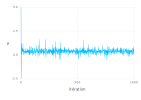

In [6]:
plot(x=1:length(μ), y=μ, Geom.line, 
    Guide.xlabel("itération"), Guide.ylabel("μ"))

### (e) Tracez la chaîne obtenue pour $\sigma^2$.

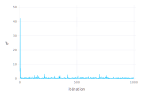

In [7]:
plot(x=1:length(σ²), y=σ², Geom.line, 
    Guide.xlabel("itération"), Guide.ylabel("σ²"))

### (f) Rejetez les itérations de la phase de chauffe

In [8]:
# Ici, la phase de chauffe est très courte. Elle se termine après quelques itérations seulement
#= On supprime les 100 premières itérations pour être certain de ne récupérer que les valeurs
 de la phase d'échantillonnage =#
deleteat!(μ,(1:100)) # enleve 1000 premieres lignes
deleteat!(σ²,(1:100)) 

900-element Vector{Float64}:
 0.22301432604459195
 0.3465855074825979
 0.1683255262798794
 0.35246971249669173
 0.5302005084163602
 0.5381487555734836
 1.2581435139678294
 0.2712148043190649
 0.23305024429484672
 0.1547507624070047
 0.24886198543286894
 0.1984497141447949
 0.20705948975420824
 ⋮
 0.27940892791131794
 0.48707158399616923
 0.17085825546094
 0.5823722653549045
 0.2051481576014503
 0.5003333998285806
 0.7860655997990275
 0.3179547980908847
 0.1879622751771368
 0.1746851460370351
 0.14269146538960292
 0.15192921974870496

### (f) Calculez la loi *a posteriori* marginale de μ

Cette loi est donnée dans l'exemple 2 des notes de cours. Calculez ses paramètres et construisez l'objet de type *UnivariateDistribution* en utiisant la fonction `LocationScale()`.

In [9]:
# la densité a posteriori marginale de µ 
# s^2=(1/(n-1))*sum from 1 to n (yi-ȳ)^2
# f(u | Y=y )(u) propor [1+[1/(n-1)][(u-ȳ)/(s/sqrt(n))]^2]^-((n-1)+1)/2
# on reconnait t_n-1(u| ȳ,s/sqrt(n))
f = LocationScale(ȳ, s/sqrt(n), TDist(n-1))

LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 0.36666666666666664
σ: 0.18262286579481526
ρ: TDist{Float64}(ν=5.0)
)


### (g) Vérifiez que la chaine générée pour μ correspond à la loi marginale

Pour vérifier que votre chaîne μ générée correspond à la loi *a posteriori* marginale de μ, comparez la densité de la loi que vous avez obtenue à la question précédente à l'histogramme de la chaine des μ. Vous pouvez même superposer la densité à l'histogramme sur le même graphique en utilisant la fonction `layer()` de Gadfly et l'option `density=true` de la géométrie `Geom.histrogram()`.

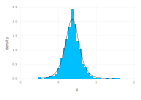

In [10]:
plot(
    layer(x->pdf(f, x), -.5, 1.5, Theme(default_color=colorant"black")),
    layer(x=μ, Geom.histogram(bincount=30, density=true)),
    Guide.xlabel("μ"), Guide.ylabel("density")
)

## Exercice 2 : Détermination de la variance de l'erreur du montage d'Illingworth

On sait aujourd'hui que le vrai déplacement des franges d'interférence est égal à 0, peu importe les conditions d'observation. On peut alors supposer le modèle suivant pour estimer la variance de l'erreur expérimentale du montage

$$ Y_i \sim \mathcal{N} \left( 0, \sigma^2 \right) ; $$

pour les 64 observations effectuées.

Nous allons d'abord vérifier si Illingworth a bien estimé l'erreur de son montage en comparant les modèles satistiques suivants :

$$ \mathcal{M}_1 : Y_i \sim \mathcal{N} \left( 0, (3/2)^2 \right) , $$
$$ \mathcal{M}_2 : Y_i \sim \mathcal{N} \left( 0, \sigma^2 \right) ; $$

le modèle $\mathcal{M}_1$ correspond à l'hypothèse d'Illingworth et le modèle $\mathcal{M}_2$ suppose une variance d'erreur différente. Si le modèle $\mathcal{M}_2$ est plus vraisemblable, alors nous estimerons la variance expérimentale du montage.

In [13]:
y = data[:,:FringeDispl]

ȳ = mean(y)
s = std(y)
n = length(y)

64

### (a) Calculez la log vraisemblance du modèle $\mathcal{M}_1$

In [12]:
# ln(f(Y|θˆMV)(y)=log product from 1 to n (1/2π(3/2)^2)*e^[-1/2(3/2)^2*(y-0)^2]
lf1 = loglikelihood(Normal(0,3/2),y)

-87.13081082179936

### (b) Calculez le bic du modèle $\mathcal{M}_1$

In [15]:
# BIC=ln(f(Y|θˆMV)(y)-k/2(ln(n))
k = 0 # nb de parametres du modele M1 donne la moy et variance reel
BICM1=lf1-k/2*log(n)

-87.13081082179936

### (c) Calculez l'estimation du maximum de la vraisemblance de σ²

Vous devez calculez à main la formule de l'estimateur en dérivant la vraisemblance puis calculez l'estimation avec les données.

In [20]:
# 𝜎̂^2=1/n*sum from 1 to n (yi)^2 (given check solution)
σ̂² = sum(y.^2)/n

0.16656875000000004

### (d) Calculez la log-vraisemblance du modèle $\mathcal{M}_2$ évaluée à σ̂²

In [22]:
# ln(f(Y|θˆMV)(y)=log product from 1 to n (1/2π(3/2)^2)*e^[-1/2(3/2)^2*(y-0)^2]
lf2 = loglikelihood(Normal(0,sqrt(σ̂²)),y)

-33.45695758513737

### (e) Calculez le BIC du modèle $\mathcal{M}_2$

In [23]:
k = 1 # le modele 2 on calcul une estimation de la variance donc variance reel inconnu-> 1 parametre pour modele
BICM2=lf2-k/2*log(n)

-35.5363991268172

### (f) Quel est le meilleur modèle ?

Selon les BIC calculés, quel est le meilleur modèle ?

In [25]:
BICM2-BICM1 # comme la difference > 2 la certitude que M1 est faux par rapport a M2 est decisive selon le tableau
# le meilleur modele est donc M2

51.594411694982156

### (g) Estimez l'écart-type expériemental σ du montage d'Illingworth

In [26]:
σ̂ = sqrt(σ̂²)

0.4081283499096823